# synpuf disclosure risk

Compare synthetic PUFs trained from a 50% sample, both to the training set and the remaining 50% holdout. Synthetic file (1) is from synthimpute random forests; (2) is from the synthpop R package.

## Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import synthimpute as si
from scipy import stats

import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter

### Graphing

In [2]:
# !wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf
# mpl.font_manager._rebuild()

In [3]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

### Load data

In [41]:
rf_synth = pd.read_csv('~/Downloads/puf_synth_50p_sample.csv').drop('S006', axis=1)
synthpop = pd.read_csv('~/Downloads/puf_synthpop_50p_sample.csv').drop('S006', axis=1)
train = pd.read_csv('~/Downloads/puf_50p_sample_train.csv').drop('S006', axis=1)
test = pd.read_csv('~/Downloads/puf_50p_sample_test.csv').drop('S006', axis=1)
nearest_rf = pd.read_csv('~/Downloads/nearest_rf_50p.csv')
nearest_synthpop = pd.read_csv('~/Downloads/nearest_synthpop_50p.csv')

## Examine results

In [5]:
nearest_rf.sort_values('train_dist').head()

,synth_id,train_id,train_dist,test_id,test_dist,dist_diff,dist_ratio
34448,34448,23513,0.0,43840,0.000000,0.000000,NaN
68843,68843,9212,0.0,61086,0.000525,-0.000525,0.0
6282,6282,16388,0.0,65520,0.012901,-0.012901,0.0
13377,13377,42997,0.0,7686,0.000000,0.000000,NaN
6280,6280,13797,0.0,38125,0.000000,0.000000,NaN


In [6]:
nearest_rf.sort_values('dist_diff').head()

,synth_id,train_id,train_dist,test_id,test_dist,dist_diff,dist_ratio
71887,71887,80041,14.591082,54459,69.193078,-54.601996,0.210875
20202,20202,15591,6.550347,31682,58.392929,-51.842582,0.112177
70902,70902,51113,38.051398,29749,88.672013,-50.620615,0.429125
42433,42433,2822,13.558506,18195,63.724763,-50.166257,0.212767
77459,77459,80041,23.293958,27604,70.250959,-46.957002,0.331582


In [7]:
nearest_synthpop.sort_values('train_dist').head()

,synth_id,train_id,train_dist,test_id,test_dist,dist_diff,dist_ratio
56549,56549,31509,0.0,71256,0.0,0.0,NaN
48468,48468,8263,0.0,161,0.0,0.0,NaN
48359,48359,23958,0.0,18882,0.0,0.0,NaN
77056,77056,3174,0.0,5909,0.0,0.0,NaN
48293,48293,5197,0.0,44813,0.0,0.0,NaN


## Analysis

In [8]:
nearest_rf[['train_dist', 'test_dist', 'dist_diff']].describe()

,train_dist,test_dist,dist_diff
count,81893.000000,81893.000000,81893.000000
mean,1.106848,1.217312,-0.110464
std,2.998745,3.423680,1.005604
min,0.000000,0.000000,-54.601996
25%,0.012110,0.026549,-0.085221
50%,0.234298,0.294962,-0.000996
75%,1.162192,1.279827,0.015130
max,141.098474,174.151800,9.593916


In [9]:
nearest_synthpop[['train_dist', 'test_dist', 'dist_diff']].describe()

,train_dist,test_dist,dist_diff
count,81893.000000,81893.000000,81893.000000
mean,1.180671,1.244418,-0.063746
std,2.698508,3.257676,1.447087
min,0.000000,0.000000,-197.787275
25%,0.062636,0.065529,-0.055549
50%,0.390299,0.402443,-0.000009
75%,1.403793,1.424372,0.032334
max,130.768999,218.831288,15.902066


In [10]:
stats.ttest_1samp(nearest_rf.dist_diff, 0)

Ttest_1sampResult(statistic=-31.43524692739095, pvalue=1.2929751067088507e-215)

In [11]:
stats.ttest_1samp(nearest_synthpop.dist_diff, 0)

Ttest_1sampResult(statistic=-12.606204910991293, pvalue=2.109917243802579e-36)

## Charts

### Scatterplots of distance to train and to test

Note we can't use log scales because of the exact zeros.

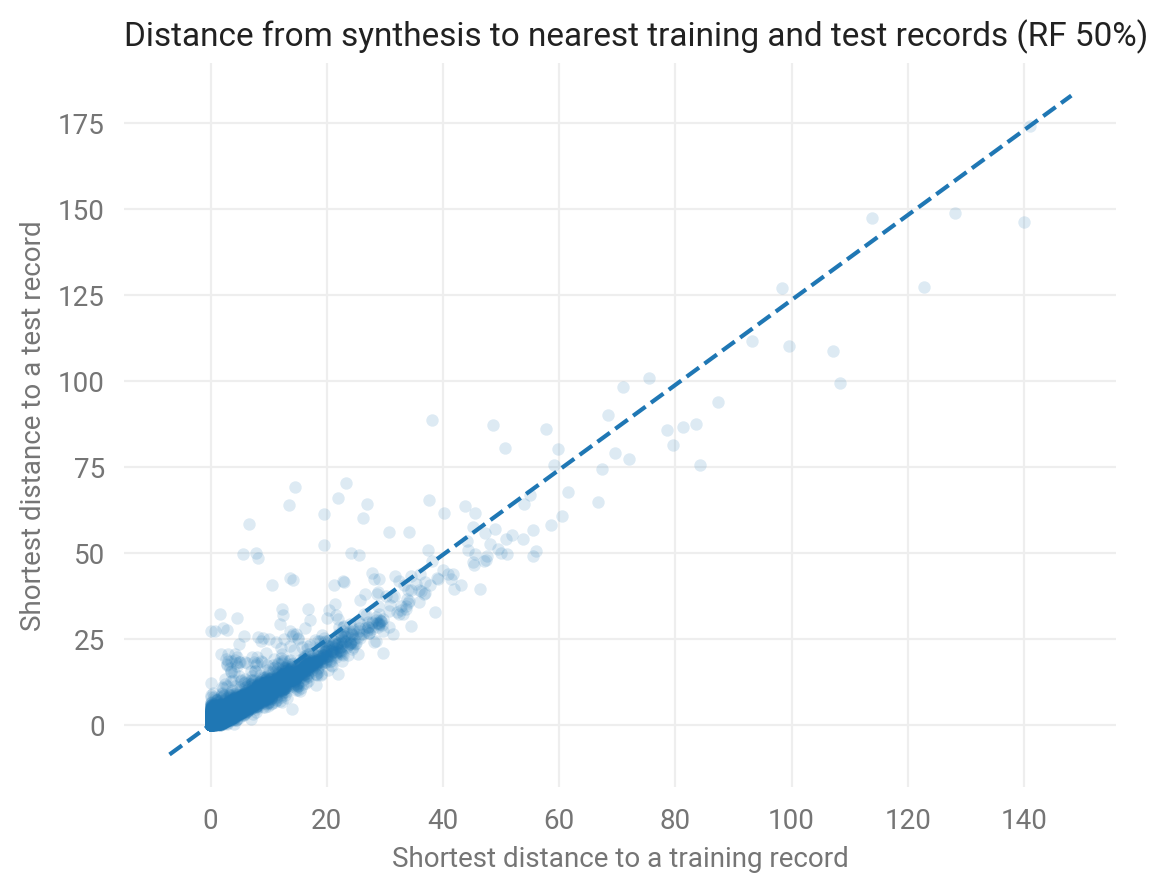

In [12]:
ax = nearest_rf.plot.scatter('train_dist', 'test_dist', alpha=0.15, linewidths=0.0)
# 45-degree line.
ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--')
sns.despine(left=True, bottom=True)
ax.grid(color='#eeeeee')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set(xlabel='Shortest distance to a training record',
       ylabel='Shortest distance to a test record')
plt.title('Distance from synthesis to nearest training and test records (RF 50%)',
          loc='left')
plt.show()

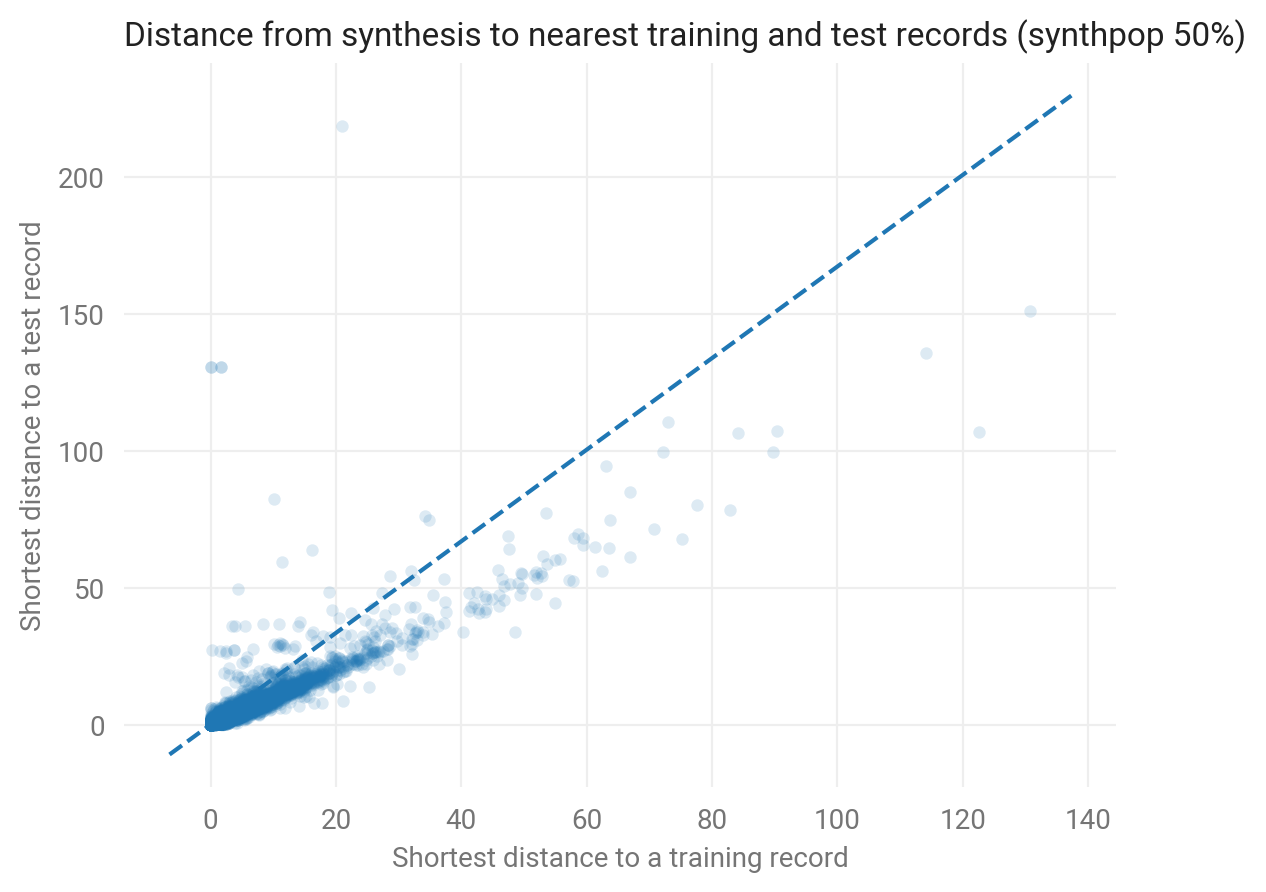

In [13]:
ax = nearest_synthpop.plot.scatter('train_dist', 'test_dist', alpha=0.15, linewidths=0.0)
# 45-degree line.
ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--')
sns.despine(left=True, bottom=True)
ax.grid(color='#eeeeee')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set(xlabel='Shortest distance to a training record',
       ylabel='Shortest distance to a test record')
plt.title('Distance from synthesis to nearest training and test records (synthpop 50%)',
          loc='left')
plt.show()

### Boxplot of distances

In [14]:
distances_stacked = pd.DataFrame({
    'type': 'train',
    'model': 'RF',
    'dist': nearest_rf.train_dist
}).append(pd.DataFrame({
    'type': 'test',
    'model': 'RF',
    'dist': nearest_rf.test_dist
})).append(pd.DataFrame({
    'type': 'train',
    'model': 'synthpop',
    'dist': nearest_synthpop.train_dist
})).append(pd.DataFrame({
    'type': 'test',
    'model': 'synthpop',
    'dist': nearest_synthpop.test_dist
}))

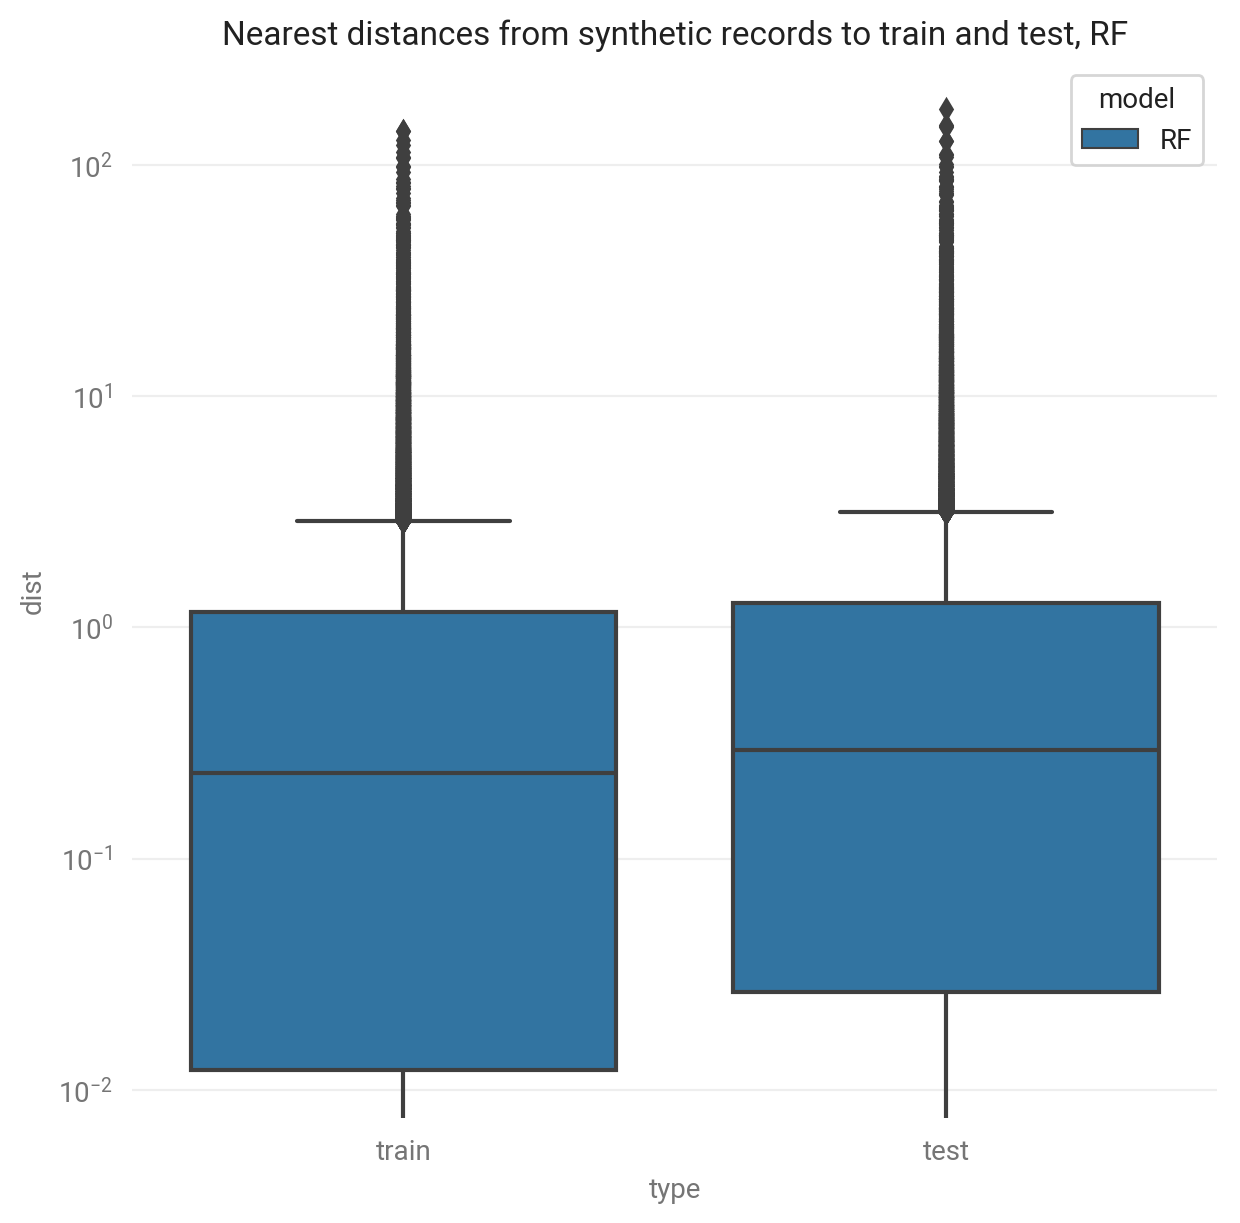

In [15]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale='log')
sns.boxplot(x='type', y='dist', hue='model',
            data=distances_stacked[distances_stacked.model == 'RF'])
sns.despine(left=True, bottom=True)
ax.yaxis.grid(color='#eeeeee')
plt.title('Nearest distances from synthetic records to train and test, RF')
plt.show()

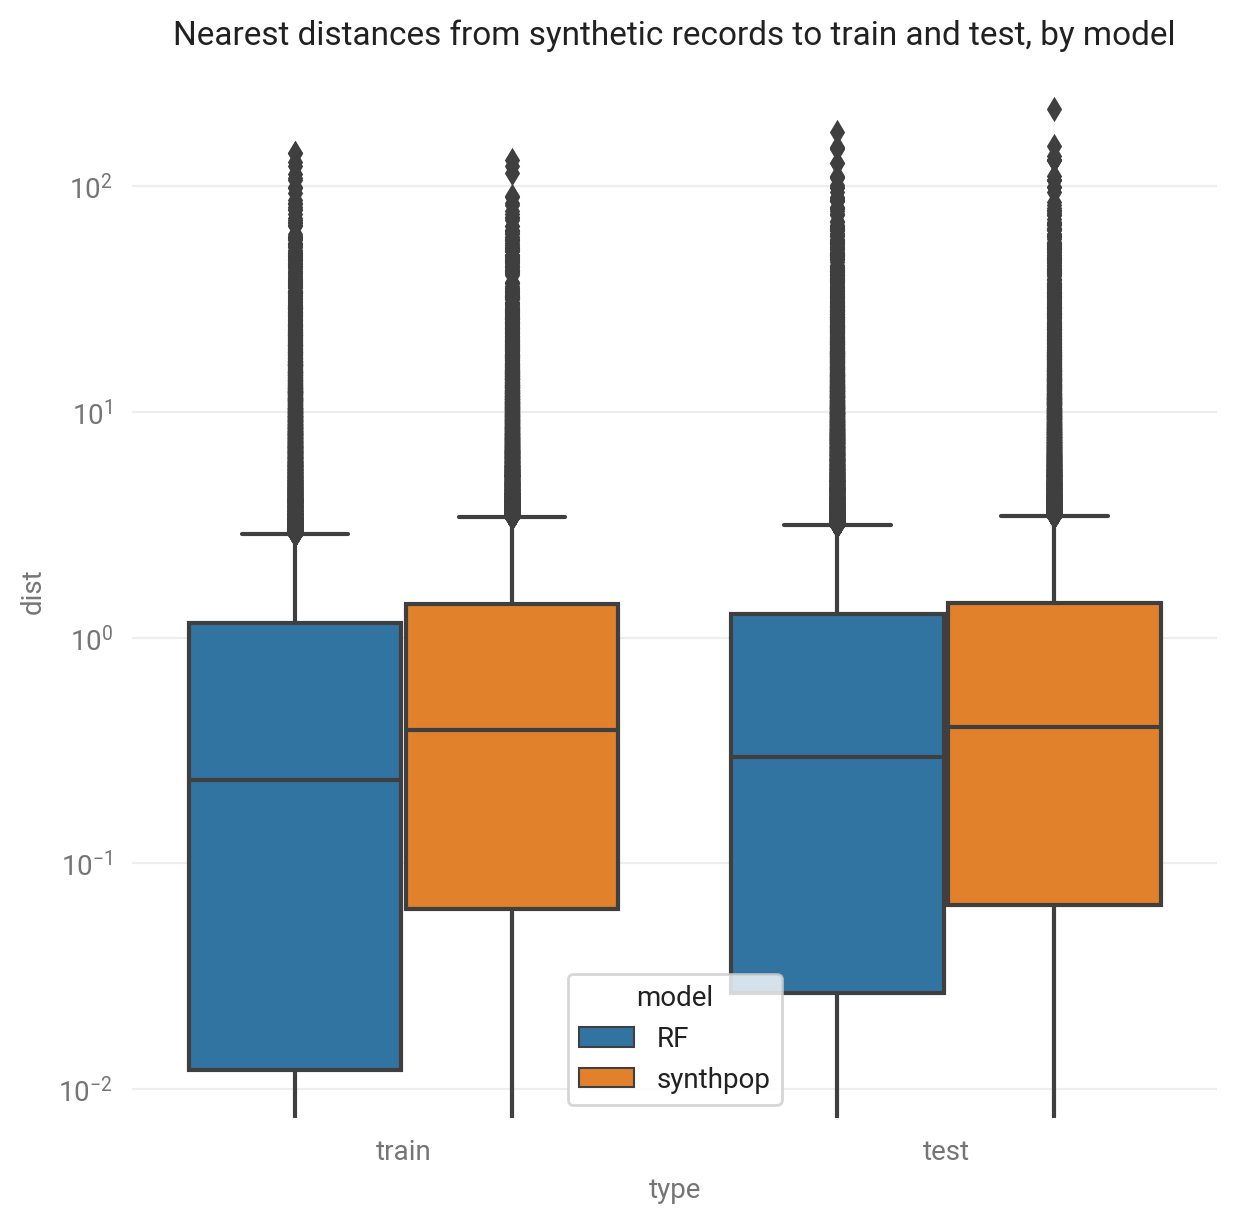

In [16]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale='log')
sns.boxplot(x='type', y='dist',
            hue='model', data=distances_stacked)
sns.despine(left=True, bottom=True)
ax.yaxis.grid(color='#eeeeee')
plt.title('Nearest distances from synthetic records to train and test, by model')
plt.show()

### CDFs of distances

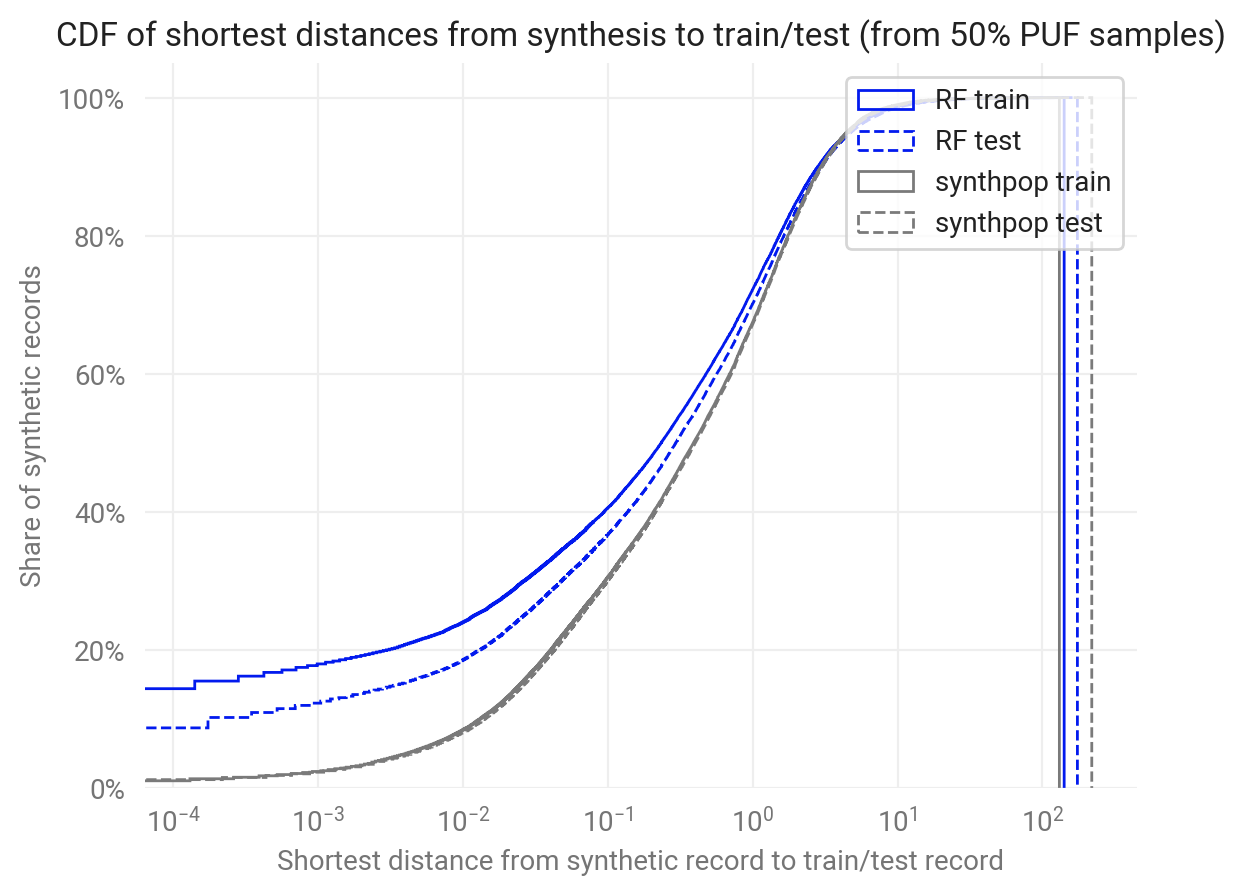

In [17]:
# Plot the four series.
BINS = 1000000
ax = nearest_rf.train_dist.hist(cumulative=True, density=1, bins=BINS, color='#021aee', histtype='step')
nearest_rf.test_dist.hist(cumulative=True, density=1, bins=BINS, histtype='step', color='#021aee', ls='--')
nearest_synthpop.train_dist.hist(cumulative=True, density=1, bins=BINS, histtype='step', color='#7a7a7a')
nearest_synthpop.test_dist.hist(cumulative=True, density=1, bins=BINS, histtype='step', color='#7a7a7a', ls='--')
# Formatting.
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
ax.grid(color='#eeeeee')
sns.despine(left=True, bottom=True)
plt.xscale('log')
plt.legend(['RF train', 'RF test', 'synthpop train', 'synthpop test'])
ax.set(xlabel='Shortest distance from synthetic record to train/test record',
       ylabel='Share of synthetic records')
plt.title('CDF of shortest distances from synthesis to train/test (from 50% PUF samples)')
plt.show()

### Exact matches

In [18]:
exact_matches = pd.DataFrame({
    'type': ['train', 'train', 'test', 'test'],
    'model': ['RF', 'synthpop', 'RF', 'synthpop'],
    'share_exact': [(nearest_rf.train_dist == 0).mean(),
                    (nearest_synthpop.train_dist == 0).mean(),
                    (nearest_rf.test_dist == 0).mean(),
                    (nearest_synthpop.test_dist == 0).mean()]})
exact_matches

,type,model,share_exact
0,train,RF,0.098421
1,train,synthpop,0.006130
2,test,RF,0.036499
3,test,synthpop,0.005287


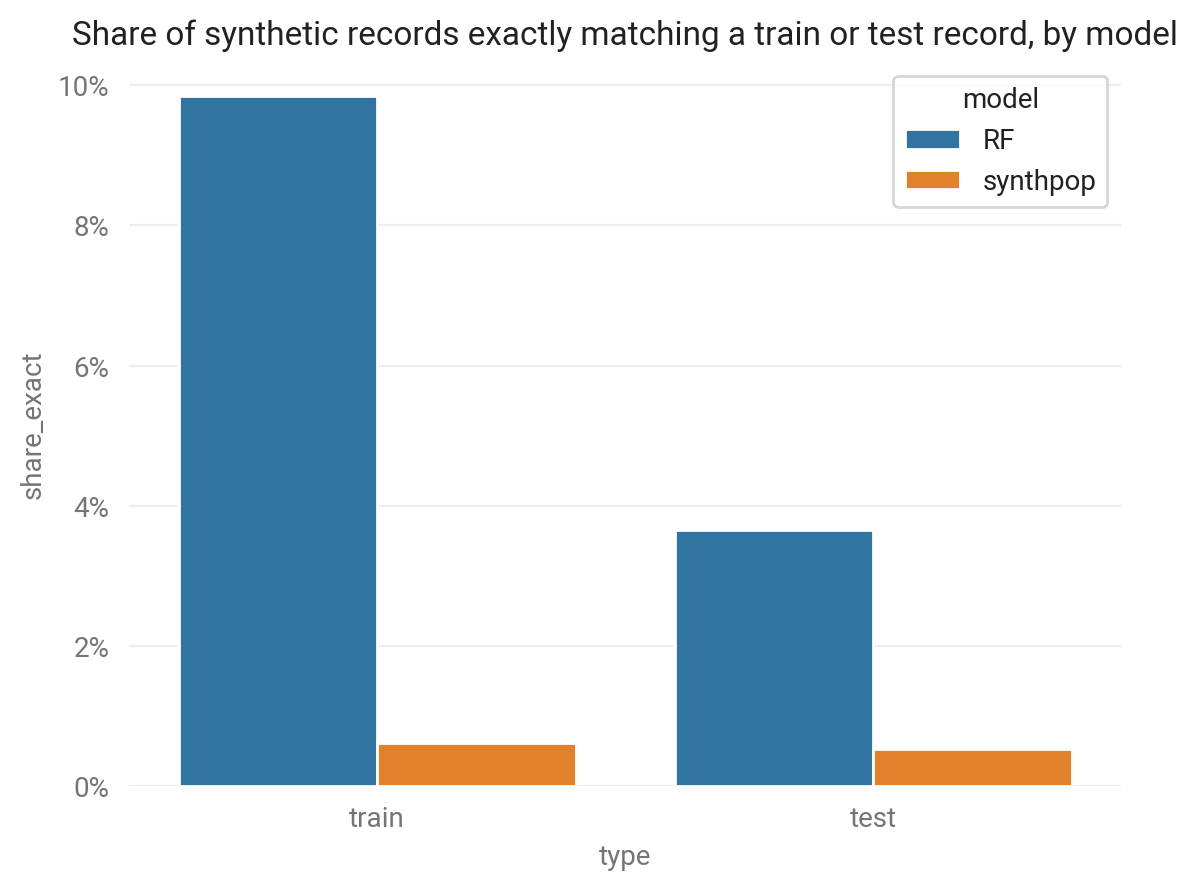

In [19]:
ax = sns.barplot(x='type', y='share_exact', hue='model', data=exact_matches)
sns.despine(left=True, bottom=True)
ax.yaxis.grid(color='#eeeeee')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
plt.title('Share of synthetic records exactly matching a train or test record, by model')
plt.show()

In [20]:
exact_matches_bool = pd.DataFrame({
    'type': 'train',
    'model': 'RF',
    'share_exact': (nearest_rf.train_dist == 0)
}).append(pd.DataFrame({
    'type': 'test',
    'model': 'RF',
    'share_exact': (nearest_rf.test_dist == 0)
})).append(pd.DataFrame({
    'type': 'train',
    'model': 'synthpop',
    'share_exact': (nearest_synthpop.train_dist == 0)
})).append(pd.DataFrame({
    'type': 'test',
    'model': 'synthpop',
    'share_exact': (nearest_synthpop.test_dist == 0)
}))

/home/maxghenis/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


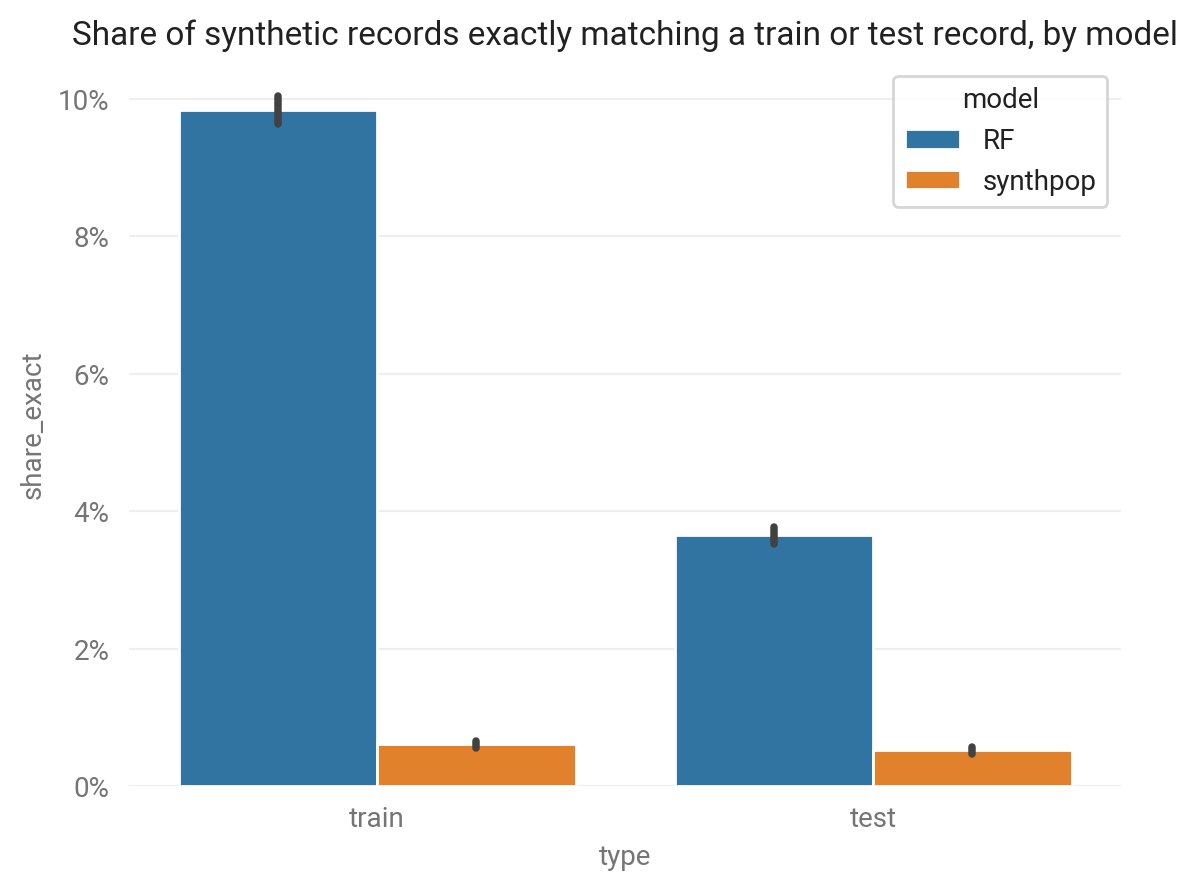

In [21]:
ax = sns.barplot(x='type', y='share_exact', hue='model', data=exact_matches_bool)
sns.despine(left=True, bottom=True)
ax.yaxis.grid(color='#eeeeee')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
plt.title('Share of synthetic records exactly matching a train or test record, by model')
plt.show()

What share of exact matches to train also exactly matched a test?

In [22]:
def share_exact_matches(df):
    exact_train = df[df.train_dist == 0]
    return((exact_train.test_dist == 0).sum() / exact_train.shape[0])

share_exact_matches(nearest_rf)

0.35074441687344915

In [23]:
share_exact_matches(nearest_synthpop)

0.7211155378486056

### Record complexity

Number of nonzero attributes.

In [43]:
rf_synth['nonzeros'] = rf_synth.astype(bool).sum(axis=1)

In [44]:
rf_synth.nonzeros.describe()

count    81893.000000
mean        14.191579
std          7.148292
min          3.000000
25%          8.000000
50%         13.000000
75%         20.000000
max         42.000000
Name: nonzeros, dtype: float64

### Identical records

In [73]:
puf = train.append(test)
pufu = puf.groupby(puf.columns.tolist(), as_index=False).size().reset_index().rename(
    columns={0:'records'})
pufu.groupby('records').size()

records
1      146559
2        1806
3         779
4         431
5         238
6         158
7          75
8          48
9          41
10         32
11         35
12         24
13         23
14         19
15         20
16         15
17         21
18         20
19         11
20         15
21         15
22         16
23         10
24          7
25          7
26         10
27          9
28          8
29          6
30          2
31          1
32          3
33          2
34          3
35          3
37          1
45          1
131         1
dtype: int64

In [74]:
pufu[pufu.records > 1].shape[0]

3916

In [75]:
pufu[pufu.records > 1].records.sum()

17227

In [78]:
def nonzero_rows(df):
    if isinstance(df, pd.Series):
        return df[df != 0]
    # If only one row, assume we're looking for nonzero columns.
    if df.shape[0] == 1:
        df = df.transpose()
    return df.loc[(df!=0).any(axis=1)]

In [77]:
most_common_puf = pufu.sort_values('records').tail(1).drop('records', axis=1)
nonzero_rows(most_common_puf)

,126004
FDED,3.0
MARS,1.0
XTOT,1.0
E87521,2500.0


In [62]:
146559/puf.shape[0]

0.8948200700914608

In [68]:
rf_synth[(rf_synth.FDED==3) & (rf_synth.MARS==1) & (rf_synth.XTOT==1) & (rf_synth.E87521==2500)]

,MARS,E00100,E09600,XTOT,F6251,MIDR,FDED,DSI,E32800,P22250,...,E07400,E00200,E07260,E02000,E03290,E02100,E24518,E00600,E01500,nonzeros
3900,1,-3117000.0,89400.0,1,1,0,3,0,0.0,0.0,...,4312.0,1416000.0,6770.0,2906006.0,0.0,0.0,0.0,0.0,0.0,19
9817,1,-1510.0,0.0,1,0,0,3,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1850.0,0.0,10
19675,1,-2575000.0,0.0,1,1,0,3,0,0.0,0.0,...,0.0,21200.0,0.0,-83800.0,0.0,0.0,0.0,0.0,0.0,10
30666,1,-300.0,0.0,1,0,0,3,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
31271,1,-11800.0,0.0,1,0,0,3,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
38179,1,-6310.0,0.0,1,1,0,3,0,0.0,-256300.0,...,0.0,0.0,0.0,-16345.0,0.0,-61456.0,0.0,550.0,0.0,16
41906,1,-10700.0,0.0,1,0,0,3,0,0.0,0.0,...,0.0,13100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
49459,1,-128500.0,0.0,1,0,0,3,0,0.0,0.0,...,0.0,0.0,0.0,101278.0,1200.0,-351300.0,0.0,1755.0,0.0,19
74393,1,-11200.0,0.0,1,0,0,3,0,0.0,0.0,...,0.0,80.0,0.0,-8920.0,0.0,0.0,0.0,870.0,0.0,10
78393,1,-710.0,0.0,1,0,0,3,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


In [70]:
synthpop[(synthpop.FDED==3) & (synthpop.MARS==1) & (synthpop.XTOT==1) & (synthpop.E87521==2500)]

,DSI,EIC,FDED,F2441,F6251,MARS,MIDR,N24,XTOT,E00200,...,E24518,E26270,E27200,E32800,E58990,E62900,E87521,E87530,E00600,E01500
10185,0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,23000.0,...,0.0,3620.0,0.0,0.0,0.0,0.0,2500.0,0.0,810.0,0.0
12057,0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2500.0,0.0,1630.0,0.0
13797,0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,29000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2500.0,0.0,0.0,0.0
13847,0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,90500.0,...,0.0,-530300.0,0.0,0.0,0.0,0.0,2500.0,0.0,0.0,0.0
17177,0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2500.0,0.0,0.0,0.0
18131,0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2500.0,0.0,3530.0,380.0
18447,0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,8670.0,...,0.0,0.0,0.0,0.0,0.0,510.0,2500.0,0.0,0.0,0.0
18937,0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,85900.0,...,0.0,601900.0,0.0,0.0,0.0,0.0,2500.0,0.0,0.0,0.0
19762,0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,107300.0,...,0.0,-495000.0,0.0,0.0,0.0,0.0,2500.0,0.0,0.0,0.0
27260,0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,30300.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2500.0,0.0,930.0,0.0


In [64]:
rf_synth.merge(most_common_puf)

,MARS,E00100,E09600,XTOT,F6251,MIDR,FDED,DSI,E32800,P22250,...,E07260,E02000,E03290,E02100,E24518,E00600,E01500,nonzeros,e00600_minus_e00650,e01500_minus_e01700


In [69]:
synthpop.merge(most_common_puf)

,DSI,EIC,FDED,F2441,F6251,MARS,MIDR,N24,XTOT,E00200,...,E58990,E62900,E87521,E87530,E00600,E01500,E00100,E09600,e00600_minus_e00650,e01500_minus_e01700
